# **1. Preprocessing for single frame**

In [11]:
from google.colab.output import eval_js
from base64 import b64decode
from IPython.display import display, Javascript

def js_capture():
    js = Javascript('''
    async function takePhoto() {
      const div = document.createElement('div');
      const video = document.createElement('video');
      const btn = document.createElement('button');
      btn.textContent = 'Capture';
      div.appendChild(video);
      div.appendChild(btn);
      document.body.appendChild(div);

      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      video.srcObject = stream;
      await video.play();

      // Resize video
      video.width = 320;
      video.height = 240;

      const canvas = document.createElement('canvas');
      canvas.width = 320;
      canvas.height = 240;

      await new Promise((resolve) => {
        btn.onclick = () => {
          canvas.getContext('2d').drawImage(video, 0, 0, 320, 240);
          stream.getTracks().forEach(t => t.stop());
          const dataUrl = canvas.toDataURL('image/jpeg', 0.8);
          div.remove();
          resolve(dataUrl);
        };
      });
      return canvas.toDataURL('image/jpeg', 0.8);
    }
    ''')
    display(js)
    data = eval_js('takePhoto()')
    return data

def dataurl_to_image(data_url):
    header, encoded = data_url.split(',', 1)
    img_bytes = b64decode(encoded)
    img_array = np.frombuffer(img_bytes, dtype=np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    return img


Now, let's capture an image from your camera, process it, and make a prediction using the trained model.

# **2. Prediction & WebCam**

<IPython.core.display.Javascript object>

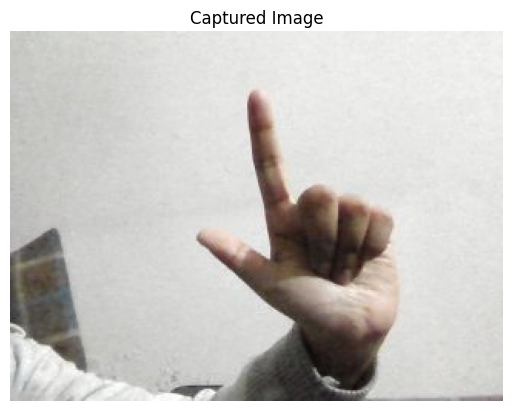

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Predicted Sign: L
Confidence: 0.97


In [17]:
# Capture image from camera
captured_image_dataurl = js_capture()
captured_img_rgb = dataurl_to_image(captured_image_dataurl)

# Display the captured image (optional)
from matplotlib import pyplot as plt
plt.imshow(cv2.cvtColor(captured_img_rgb, cv2.COLOR_BGR2RGB))
plt.title("Captured Image")
plt.axis('off')
plt.show()

# Preprocess the captured image for the model
processed_img = cv2.resize(captured_img_rgb, (IMG_SIZE, IMG_SIZE))
processed_img = np.expand_dims(processed_img, axis=0) / 255.0 # Add batch dimension and normalize

# Make prediction
prediction = model.predict(processed_img)
predicted_class_index = np.argmax(prediction)
predicted_label = le.inverse_transform([predicted_class_index])

print(f"Predicted Sign: {predicted_label[0]}")
print(f"Confidence: {np.max(prediction):.2f}")


In [30]:
get_ipython().system('pip install mediapipe')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 80.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 12.4 MB/s eta 0:00:00
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0


In [2]:
get_ipython().system('pip uninstall -y mediapipe')
get_ipython().system('pip install mediapipe==0.10.13')

import sys
# Remove mediapipe from sys.modules to force a fresh import
if 'mediapipe' in sys.modules:
    del sys.modules['mediapipe']

import mediapipe as mp

mp_hands = mp.solutions.hands.Hands(
    static_image_mode=False,
    max_num_hands=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

print("MediaPipe Hands solution initialized.")

Found existing installation: mediapipe 0.10.13
Uninstalling mediapipe-0.10.13:
  Successfully uninstalled mediapipe-0.10.13
  Using cached mediapipe-0.10.13-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.7 kB)
Using cached mediapipe-0.10.13-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (35.6 MB)
MediaPipe Hands solution initialized.


# **3.process_and_predict_hand_sign**

In [3]:
mp_drawing = mp.solutions.drawing_utils

def process_and_predict_hand_sign(image_bgr):
    h, w, c = image_bgr.shape
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    results = mp_hands.process(image_rgb)

    annotated_image_bgr = image_bgr.copy()

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Draw hand landmarks (optional, but good for visualization)
            mp_drawing.draw_landmarks(annotated_image_bgr, hand_landmarks, mp.solutions.hands.HAND_CONNECTIONS)

            # Extract bounding box
            x_min, y_min = w, h
            x_max, y_max = 0, 0
            for landmark in hand_landmarks.landmark:
                x, y = int(landmark.x * w), int(landmark.y * h)
                x_min = min(x_min, x)
                y_min = min(y_min, y)
                x_max = max(x_max, x)
                y_max = max(y_max, y)

            # Expand bounding box slightly and clamp to image boundaries
            padding = 20
            x_min = max(0, x_min - padding)
            y_min = max(0, y_min - padding)
            x_max = min(w, x_max + padding)
            y_max = min(h, y_max + padding)

            # Crop hand region
            cropped_hand = image_bgr[y_min:y_max, x_min:x_max]

            if cropped_hand.size == 0:
                # If cropped area is empty (e.g., due to extreme clamping), skip prediction for this hand
                continue

            # Preprocess for model
            processed_img = cv2.resize(cropped_hand, (IMG_SIZE, IMG_SIZE))
            processed_img = np.expand_dims(processed_img, axis=0) / 255.0

            # Make prediction
            prediction = model.predict(processed_img, verbose=0)
            predicted_class_index = np.argmax(prediction)
            predicted_label = le.inverse_transform([predicted_class_index])[0]
            confidence = np.max(prediction)

            # Draw bounding box and text on the original image
            cv2.rectangle(annotated_image_bgr, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            text = f"{predicted_label}: {confidence:.2f}"
            cv2.putText(
                annotated_image_bgr, text, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2, cv2.LINE_AA
            )
    else:
        text = "No Hand Detected"
        cv2.putText(
            annotated_image_bgr, text, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA
        )

    return cv2.cvtColor(annotated_image_bgr, cv2.COLOR_BGR2RGB)

print("Function 'process_and_predict_hand_sign' defined.")

Function 'process_and_predict_hand_sign' defined.


In [4]:
from google.colab.output import eval_js
from base64 import b64decode
from IPython.display import display, Javascript

def js_capture():
    js = Javascript('''
    async function takePhoto() {
      const div = document.createElement('div');
      const video = document.createElement('video');
      const btn = document.createElement('button');
      btn.textContent = 'Capture';
      div.appendChild(video);
      div.appendChild(btn);
      document.body.appendChild(div);

      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      video.srcObject = stream;
      await video.play();

      // Resize video
      video.width = 320;
      video.height = 240;

      const canvas = document.createElement('canvas');
      canvas.width = 320;
      canvas.height = 240;

      await new Promise((resolve) => {
        btn.onclick = () => {
          canvas.getContext('2d').drawImage(video, 0, 0, 320, 240);
          stream.getTracks().forEach(t => t.stop());
          const dataUrl = canvas.toDataURL('image/jpeg', 0.8);
          div.remove();
          resolve(dataUrl);
        };
      });
      return canvas.toDataURL('image/jpeg', 0.8);
    }
    ''')
    display(js)
    data = eval_js('takePhoto()')
    return data

In [5]:
from tensorflow.keras.models import load_model
import pickle
import cv2
import numpy as np

IMG_SIZE = 64

# Load once
model = load_model("asl_cnn_model.h5")
with open("label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

def process_and_predict_hand_sign(img_bgr):


    # Optional: center crop a square ROI (hand area approx. middle of frame)
    h, w, _ = img_bgr.shape
    size = min(h, w)
    x1 = w // 2 - size // 2
    y1 = h // 2 - size // 2
    x2 = x1 + size
    y2 = y1 + size
    roi = img_bgr[y1:y2, x1:x2]

    # Preprocess for model
    roi_resized = cv2.resize(roi, (IMG_SIZE, IMG_SIZE))
    roi_norm = roi_resized.astype("float32") / 255.0
    roi_norm = np.expand_dims(roi_norm, axis=0)

    # Predict
    preds = model.predict(roi_norm, verbose=0)
    idx = int(np.argmax(preds))
    conf = float(np.max(preds))
    label = le.inverse_transform([idx])[0]

    # Draw ROI and label back on full frame
    cv2.rectangle(img_bgr, (x1, y1), (x2, y2), (255, 255, 255), 2)
    cv2.putText(img_bgr, f"{label} ({conf:.2f})",
                (x1 + 10, y1 + 40),
                cv2.FONT_HERSHEY_SIMPLEX, 1,
                (0, 255, 0), 2)

    # Convert BGR → RGB for display
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    return img_rgb


In [6]:
def process_and_predict_hand_sign(img_bgr):


    # Preprocess exactly like training
    resized = cv2.resize(img_bgr, (IMG_SIZE, IMG_SIZE))
    x = resized.astype("float32") / 255.0
    x = np.expand_dims(x, axis=0)

    preds = model.predict(x, verbose=0)
    idx = int(np.argmax(preds))
    conf = float(np.max(preds))
    label = le.inverse_transform([idx])[0]

    # Draw label on the same frame
    cv2.putText(img_bgr, f"{label} ({conf:.2f})",
                (20, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 1,
                (0, 255, 0), 2)

    # Convert once for Colab display
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    return img_rgb


# **4. Real Time Prediction**

In [7]:
from IPython.display import display, Javascript, Image, HTML
from google.colab.output import eval_js
import google.colab.output as output_module
from base64 import b64decode, b64encode
import cv2
import numpy as np


def dataurl_to_image(data_url):
    header, encoded = data_url.split(',', 1)
    img_bytes = b64decode(encoded)
    img_array = np.frombuffer(img_bytes, dtype=np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    return img


# Display handle for live updated image
live_image_handle = None


def live_prediction_loop_with_update():
    """
    Starts a live webcam stream in Colab and sends frames
    to Python for prediction every ~100 ms.
    """
    global live_image_handle

    # Container with video and stop button
    display(HTML('''
        <div id="live-camera-container">
            <video id="live-camera-video"
                   style="display:block; width:640px; height:480px;"></video>
            <button id="stop-camera-button">Stop Capture</button>
        </div>
    '''))

    # Initialize an empty black frame as placeholder
    dummy_frame = np.zeros((480, 640, 3), dtype=np.uint8)
    _, buf = cv2.imencode('.jpeg', dummy_frame)
    dummy_b64 = b64encode(buf).decode('utf-8')
    live_image_handle = display(Image(data=b64decode(dummy_b64)), display_id=True)

    js_code = Javascript('''
        async function liveCaptureStream() {
            console.log('liveCaptureStream started.');
            const video = document.getElementById('live-camera-video');
            const stopButton = document.getElementById('stop-camera-button');

            if (!video || !stopButton) {
                console.error('Required DOM elements not found.');
                return;
            }

            try {
                const stream = await navigator.mediaDevices.getUserMedia({video: true});
                video.srcObject = stream;
                await video.play();
                console.log('Camera stream started successfully.');

                const canvas = document.createElement('canvas');
                canvas.width = video.videoWidth || 640;
                canvas.height = video.videoHeight || 480;
                const ctx = canvas.getContext('2d');

                let intervalId = setInterval(() => {
                    ctx.drawImage(video, 0, 0, canvas.width, canvas.height);
                    const photo = canvas.toDataURL('image/jpeg', 0.8);
                    google.colab.kernel.invokeFunction(
                        'notebook.live_prediction_callback',
                        [photo],
                        {}
                    );
                }, 100); // ~10 FPS

                stopButton.onclick = () => {
                    console.log('Stop Capture clicked.');
                    clearInterval(intervalId);
                    stream.getTracks().forEach(track => track.stop());
                    const container = document.getElementById('live-camera-container');
                    if (container) container.remove();
                    google.colab.kernel.invokeFunction(
                        'notebook.stop_live_prediction',
                        [],
                        {}
                    );
                };
            } catch (err) {
                console.error('Error accessing camera:', err);
                const errorDiv = document.createElement('div');
                errorDiv.innerText =
                    'Error: Camera access denied or failed. ' +
                    'Please allow camera permissions in your browser.';
                errorDiv.style.color = 'red';
                const container = document.getElementById('live-camera-container');
                if (container) container.appendChild(errorDiv);
                if (stopButton) stopButton.remove();
            }
        }
        liveCaptureStream();
    ''')
    display(js_code)


def live_prediction_callback(image_dataurl):
    """
    Called from JS for each frame.
    Expects process_and_predict_hand_sign(img_bgr) -> annotated RGB image.
    """
    global live_image_handle

    img_bgr = dataurl_to_image(image_dataurl)

    # You must define this function elsewhere:
    # it should predict and draw the letter on the frame.
    annotated_img_rgb = process_and_predict_hand_sign(img_bgr)

    # Convert RGB back to BGR for encoding
    annotated_bgr = cv2.cvtColor(annotated_img_rgb, cv2.COLOR_RGB2BGR)
    _, buffer = cv2.imencode('.jpeg', annotated_bgr)
    img_bytes = buffer.tobytes()

    if live_image_handle:
        live_image_handle.update(Image(data=img_bytes))


def stop_live_prediction():
    """
    Optional cleanup when the JS stop button is pressed.
    """
    global live_image_handle
    if live_image_handle:
        live_image_handle.update(Image(data=b''))
        live_image_handle = None
    print("Live prediction stopped.")


# Register callbacks so JS can call into Python
output_module.register_callback('notebook.live_prediction_callback',
                                live_prediction_callback)
output_module.register_callback('notebook.stop_live_prediction',
                                stop_live_prediction)

# Start the continuous live prediction loop
live_prediction_loop_with_update()


<IPython.core.display.Javascript object>

Live prediction stopped.
